In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import json
# import cv2
import subprocess
from pathlib import Path
# from PIL import Image
import keras
from IPython.display import display
from IPython.display import Markdown as md
import zipfile

In [447]:
model_path = Path('Models/Frame/vulpe_grigorasi_SadHappy/Run_1')
model_name = model_path.parts[2]

In [448]:
keras_path = [i for i in model_path.glob('*.keras')][0]

In [449]:
try:
    model = tf.keras.models.load_model(keras_path)
    model_lr = tf.keras.backend.eval(model.optimizer.lr)
    model_config = model.get_config()
    model_loss_name = type(model.loss).__name__
    model_optimizer_name = type(model.optimizer).__name__
except OSError:
    with zipfile.ZipFile(keras_path) as zf:
        path = zipfile.Path(zf, at='metadata.json')
        model_metadata = json.loads(path.read_text(encoding='UTF-8'))
        path = zipfile.Path(zf, at='config.json')
        model_general_config = json.loads(path.read_text(encoding='UTF-8'))
        model_config = model_general_config['config']
        model_compile_config = model_general_config['compile_config']
        model_loss_name = model_compile_config['loss']['config']['name']
        model_optimizer_name = model_compile_config['optimizer']['config']['name']
        model_lr = model_compile_config['optimizer']['config']['learning_rate']

model_layers = model_config['layers']

input_layer = model_layers[0]
input_shape = input_layer['config']['batch_input_shape']

output_layer = model_layers[-1]
output_units = output_layer['config']['units']
output_activation = output_layer['config']['activation']

In [450]:
# Calculate number of classes
# If outoutput_units == 1, it is a binary classification
N_CLASSES = output_units if output_units > 1 else 2

In [451]:
md(f'## Modello: {model_name} - {N_CLASSES} emozioni')

## Modello: vulpe_grigorasi_SadHappy - 2 emozioni

In [452]:
if (Path(model_path, 'note.txt').is_file()):
    with open(Path(model_path, 'note.txt'), 'r') as res_file:
        lines = res_file.read()
        display(md(f'### Note\n {lines}'))

In [453]:
display(md('### Model Info'))
print(f'''
---
Model: {model_name} in {model_path}
---
Input Shape: {input_shape}
Output: Units: {output_units}, Activation: {output_activation}
---
Loss type: {model_loss_name}
Optimizer: {model_optimizer_name} with lr: {model_lr:.2e}

''')

### Model Info


---
Model: vulpe_grigorasi_SadHappy in Models\Frame\vulpe_grigorasi_SadHappy\Run_1
---
Input Shape: [None, 64, 64, 3]
Output: Units: 2, Activation: softmax
---
Loss type: sparse_categorical_crossentropy
Optimizer: Adam with lr: 2.00e-05




In [454]:
test_loss = 0
test_acc = 0

In [455]:
dataset_file = ''
dataset_ext = ''
dataset_glob = [(i, i.suffix) for i in model_path.glob('*dataset.*')]

In [456]:
if (dataset_glob):
    dataset_file, dataset_ext = dataset_glob[0]

    display(md('#### Dataset</br>'))
    if (dataset_ext == '.csv'):
        dataset = pd.read_csv(
            dataset_file, sep=';', header=None,
            index_col=0, names=['key', 'value']
        )

        display(dataset.style.set_table_styles({
            'value': [{'selector': '',
                       'props': [('width', '600px')]}],
        }, overwrite=False))
    elif (dataset_ext == '.txt'):
        with open(dataset_file, 'r') as res_file:
            lines = res_file.read()
            print(lines)

#### Dataset</br>

Train indexes: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16']
Train files: 17826
Val indexes: ['17', '18', '19', '20']
Val files: 4550
Test indexes: ['21', '22', '23', '24']
Test files: 4842



In [457]:
result_file = ''
result_ext = ''
result_glob = [(i, i.suffix) for i in model_path.glob('*result.*')]

In [458]:
if (result_glob):
    result_file, result_ext = result_glob[0]
    display(md('#### History</br>'))
    if (result_ext == '.csv'):
        result = pd.read_csv(
            Path(model_path, "result.csv"), sep=';',
            header=None,
            index_col=0,
            names=['res_key', 'res_val']
        )

        df_rows = result.index

        # Convert rows value in np array
        for index, row in result.iterrows():
            row.res_val = np.round(eval(row.res_val), 4)

        # train_loss_min_idx = train_loss.argmin()
        # val_loss_min_idx = val_loss.argmin()

        # train_acc_max_idx = train_acc.argmax()
        # val_acc_max_idx = val_acc.argmax()
        test_loss = result.loc['loss_test'].res_val
        test_acc = result.loc['accuracy_test'].res_val

        display(result.style.set_table_styles({
            'res_val': [{'selector': '',
                       'props': [('width', '600px')]}],
        }, overwrite=False))

    elif (result_ext == '.txt'):
        test_csv = pd.read_csv(
            result_file, sep=':',
            header=None,
            index_col=0,
            names=['res_key', 'res_val'])
        for index, row in test_csv.iterrows():
            row.res_val = np.round(eval(row.res_val), 4)
        display(test_csv.style.set_table_styles({
            'res_val': [{'selector': '',
                       'props': [('width', '600px')]}],
        }, overwrite=False))

        test_loss = test_csv.loc['Test loss'].res_val
        test_acc = test_csv.loc['Test accuracy'].res_val


#### History</br>

,res_val
res_key,
BATCH,32
Train loss,[0.2204 0.0864 0.0792 0.0523 0.0373 0.0233 0.0327 0.0307 0.0123 0.0104 0.0085 0.0069 0.0078]
val_loss,[3.1709 1.0676 0.829 1.8336 0.9998 0.9499 1.409 2.3047 1.0287 1.2296 1.2667 1.3263 1.3236]
Train accuracy,[0.9137 0.9688 0.9699 0.9808 0.9861 0.9921 0.9881 0.9898 0.9961 0.9962 0.9969 0.9979 0.9971]
Train val_accuracy,[0.6235 0.6736 0.7525 0.7262 0.7925 0.753 0.7264 0.6389 0.7424 0.7534 0.7352 0.7587 0.7499]
Test loss,0.741900
Test accuracy,0.724900
Mean epoch time,98.313900


## Training

In [459]:
accuracy = plt.imread(Path(model_path, 'accuracy.png'))
loss = plt.imread(Path(model_path, 'loss.png'))

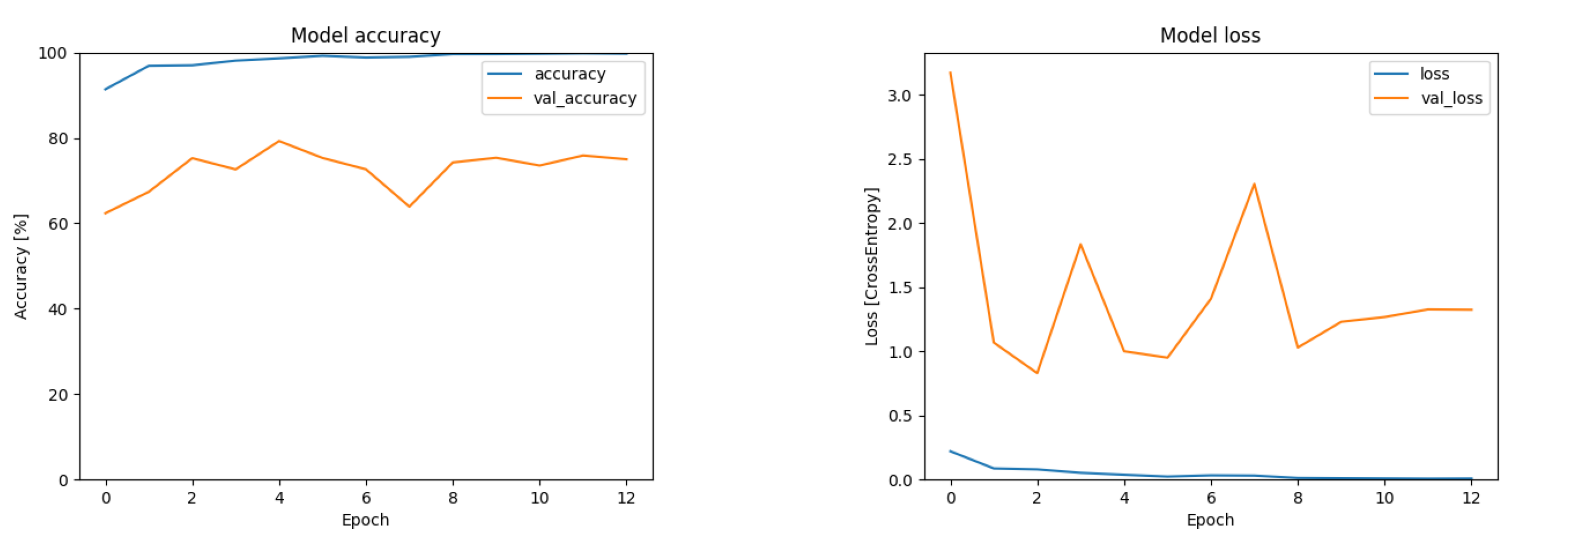

In [460]:
fig, ax = plt.subplots(
    nrows=1, ncols=2, width_ratios=[0.5, 0.5], figsize=(20 , 10)
)

# fig.set_figheight(40)
# fig.set_figwidth(40)

ax[0].axis('off')
ax[0].imshow(accuracy[20:-10, 20:-10])

ax[1].imshow(loss[20:-10, 20:-10])
ax[1].axis('off')
plt.show()

## Testing

In [461]:
md(f'''| | | | | | |
| -- | -- | -- | -- | -- | -- |
| **Loss** | {test_loss:.4f} | | | **Accuracy** | {test_acc:.4f} |''')

| | | | | | |
| -- | -- | -- | -- | -- | -- |
| **Loss** | 0.7419 | | | **Accuracy** | 0.7249 |

#### Heatmap

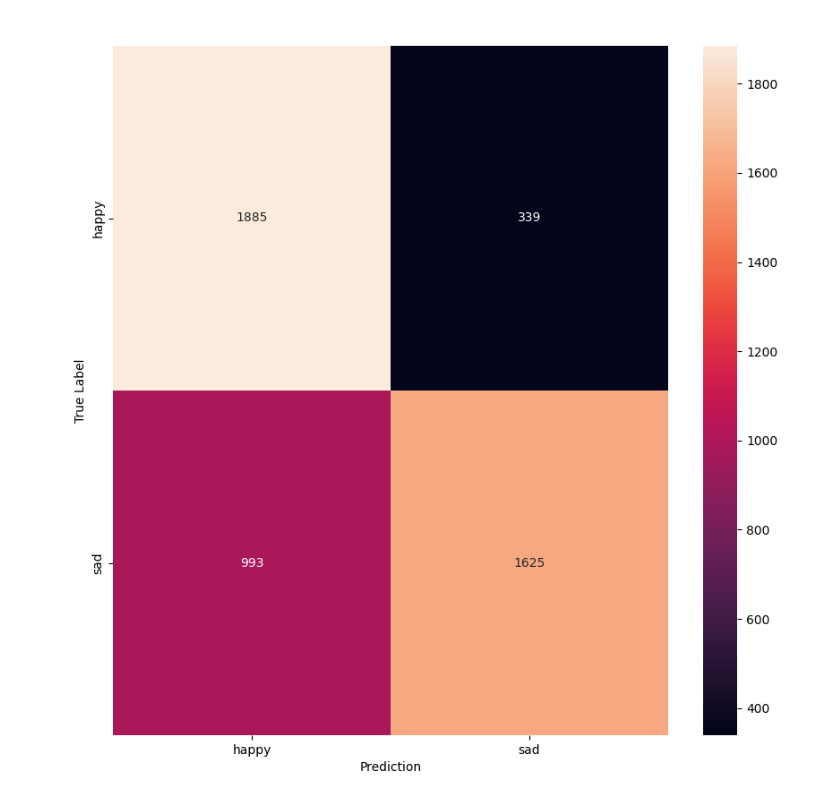

In [462]:
heatmap_file = [i for i in model_path.glob('*heat*')][0]
heatmap = plt.imread(heatmap_file)
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(20, 10)
)
ax.axis('off')
ax.imshow(heatmap[80:-60, 10:-100])
plt.show()

In [463]:
f1_score_glob = [i for i in model_path.glob('*f1_score*')]

#### F1 Score</br>

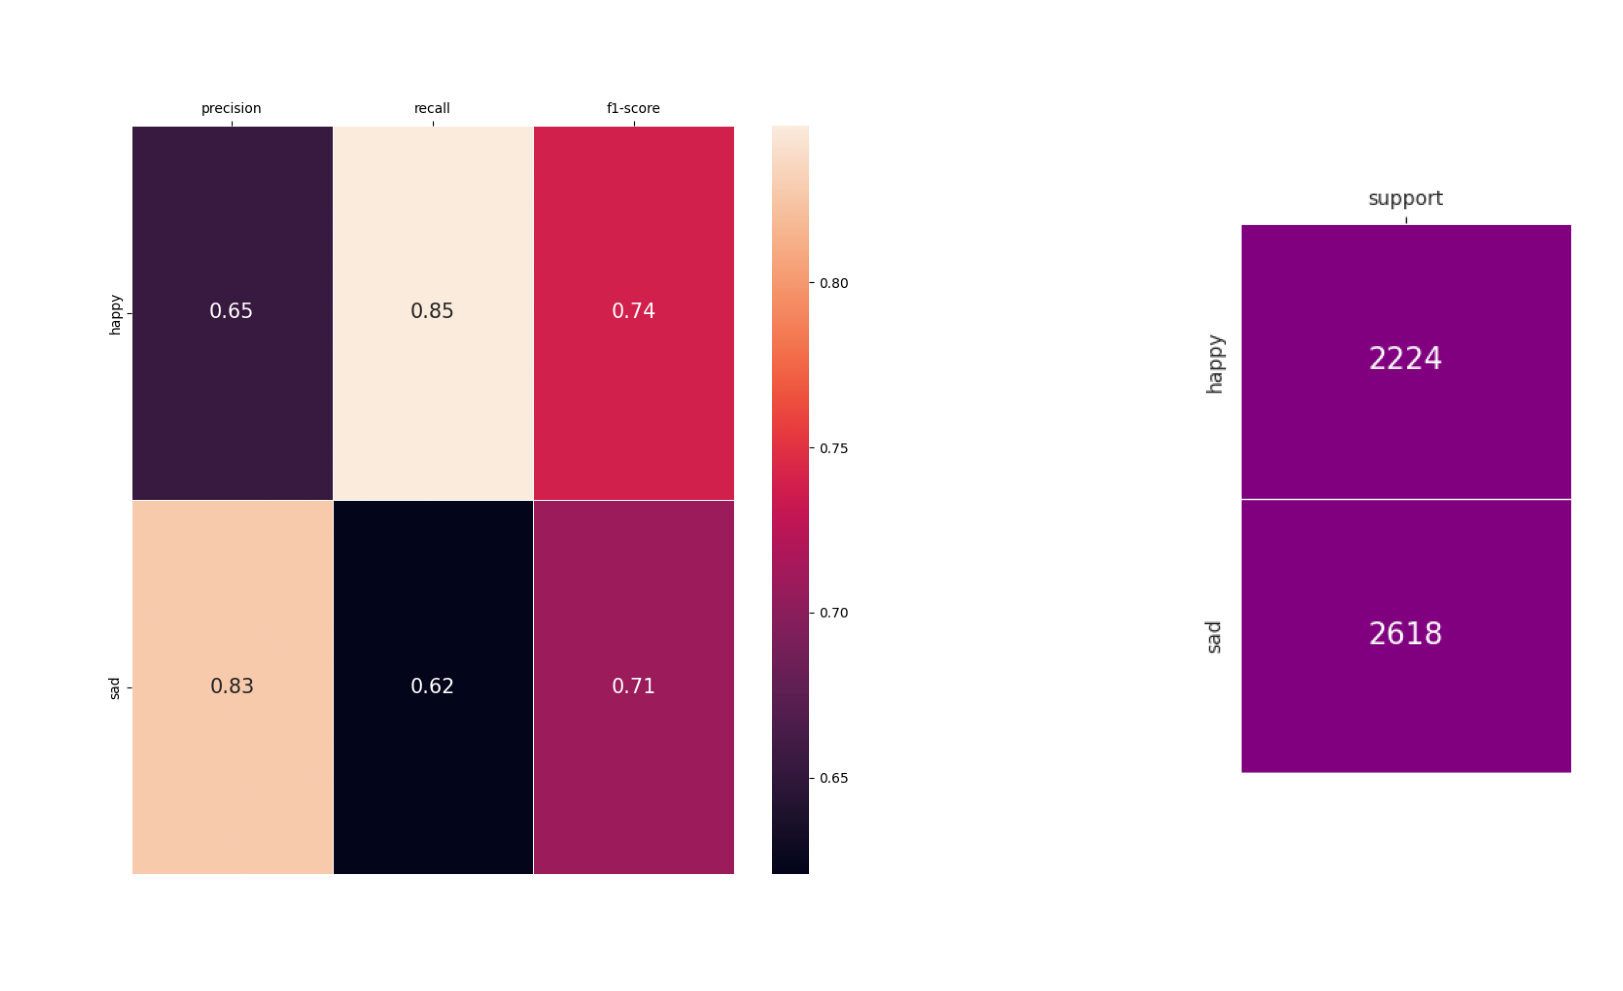

In [464]:
if (f1_score_glob):

    f1_score_file = f1_score_glob[0]
    support_file = [i for i in model_path.glob('*support.*')][0]

    f1_score = plt.imread(f1_score_file)
    support = plt.imread(support_file)
    display(md('#### F1 Score</br>'))
    fig, ax = plt.subplots(
        nrows=1, ncols=2, width_ratios=[0.8, 0.2], figsize=(20, 10)
    )

    # fig.set_figheight(40)
    # fig.set_figwidth(40)

    ax[0].axis('off')
    ax[0].imshow(f1_score)

    ax[1].axis('off')
    ax[1].imshow(support)

    plt.tight_layout(pad=1.02)
    _ = plt.show()

In [465]:
roc_glob = [i for i in model_path.glob('*ROC.*')]

#### ROC</br>

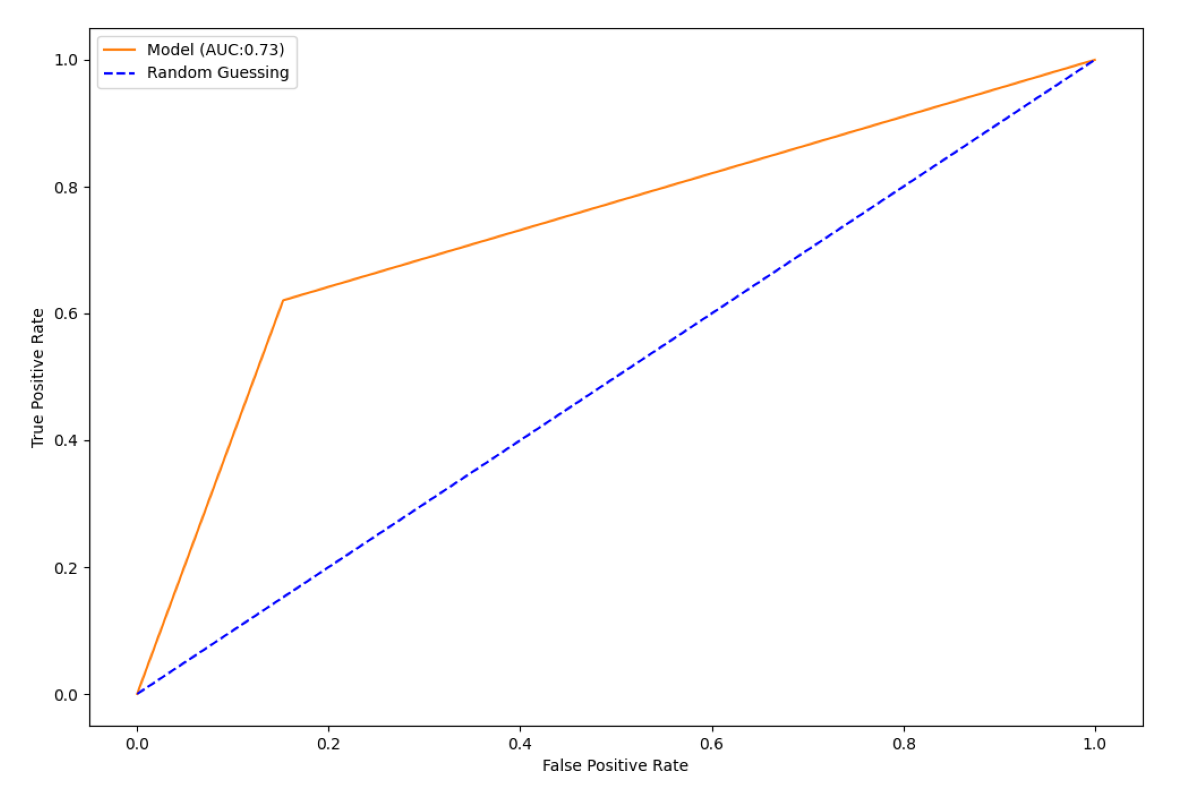

In [466]:
if (roc_glob):
    ROC_file = roc_glob[0]
    roc = plt.imread(ROC_file)
    display(md('#### ROC</br>'))
    fig, ax = plt.subplots(
        nrows=1, ncols=1, figsize=(20, 10)
    )
    ax.axis('off')
    ax.imshow(roc[80:-40, 80:-80])
    plt.show()

In [467]:
prob_file_names = [f'{model_name}.png', 'network.png']

structure_file = ''
for i in prob_file_names:
    if(Path(model_path, i).is_file()):
        structure_file = i
        break

In [468]:
if (structure_file):

    structure = plt.imread(Path(model_path, structure_file))
    display(md('#### Struttura</br>'))
    fig, ax = plt.subplots(
        nrows=1, ncols=2, figsize=(10, 10)
    )
    net_shape = structure.shape
    cutoff = net_shape[0] // 2 - 50
    ax[0].axis('off')
    ax[0].imshow(
        structure[:cutoff, :]
    )

    ax[1].axis('off')
    ax[1].imshow(
        structure[cutoff:, :]
    )
    plt.show()

In [469]:
dist_true_file_glob = [i for i in model_path.glob('*trueDist.png*')]

#### Testing Distribution</br>

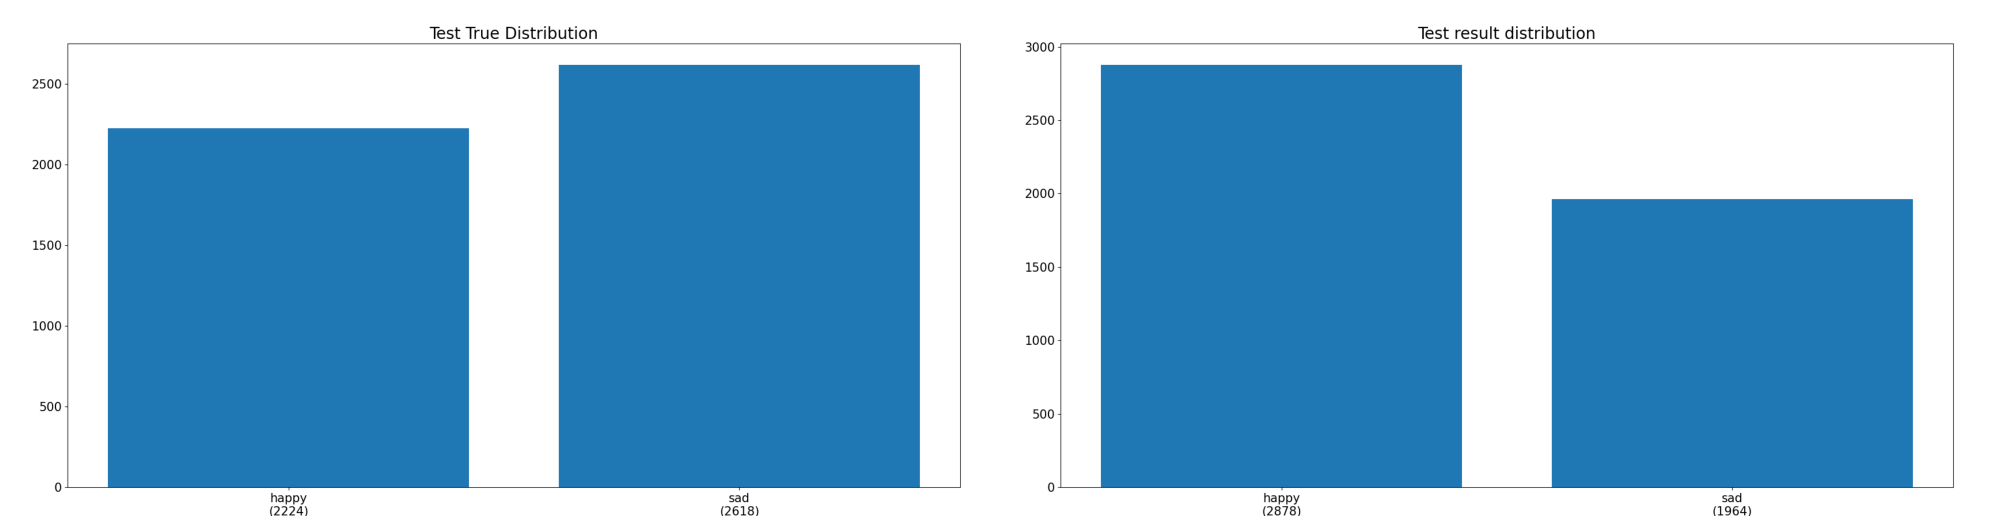

In [470]:
if (dist_true_file_glob):
    dist_true_file = [i for i in model_path.glob('*trueDist.png')][0]
    dist_pred_file = [i for i in model_path.glob('*predDist.png')][0]

    dist_true = plt.imread(dist_true_file)
    dist_pred = plt.imread(dist_pred_file)
    display(md('#### Testing Distribution</br>'))
    fig, ax = plt.subplots(
        nrows=1, ncols=2, figsize=(20, 10)
    )

    # fig.set_figheight(40)
    # fig.set_figwidth(40)

    ax[0].axis('off')
    ax[0].imshow(dist_true[60:-60, 150:-150])

    ax[1].axis('off')
    ax[1].imshow(dist_pred[60:-60, 150:-150])

    plt.tight_layout(pad=1.02)
    _ = plt.show()

In [471]:
command = f'jupyter nbconvert --to html --no-input --output-dir {model_path} ModelResults.ipynb'
subprocess.run(command, capture_output=False)
print()